In [41]:
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline 
import matplotlib_venn
import re 
import numpy as np 
import glob
import gzip 

import os 
output_dir = '../output/extracting_string_interactions/'
if not os.path.exists(output_dir): os.makedirs(output_dir)

## Loading protein information from StringDB

In [42]:
prot_fn = '../data/StringDB/9606.protein.info.v11.0.txt'
prot_data = {}
stringbd_synapse_genes = set()
with open(prot_fn) as f: 
    next(f)
    for line in f: 
        gene_id, gene_name, prot_size, anno = line.strip().split('\t') 
        synapse_anno = True if re.search('[Ss]ynap', anno) else False
        if synapse_anno: 
            stringbd_synapse_genes.add(gene_name)
        prot_data[gene_id] = [gene_name, prot_size, anno]

## Loading synapse gene data

In [43]:
synapse_fn = '../data/synapse_genes.txt'
with open(synapse_fn) as f:
    synapse_genes = set([x.strip() for x in f])

In [44]:
omim_fns = glob.glob('../output/omim_psychiatric_disease_genes/*')
omim_diease_genes = []
for fn in omim_fns:
    with open(fn) as f:
        genes = [x.strip() for x in f.readlines()]
        omim_diease_genes.extend(genes)

In [45]:
synapse_genes = synapse_genes.union(set(omim_diease_genes))

## Analyzing the difference between the synapse gene sets 

In [46]:
def transform(x, size=18):
    text.set_fontsize(size)

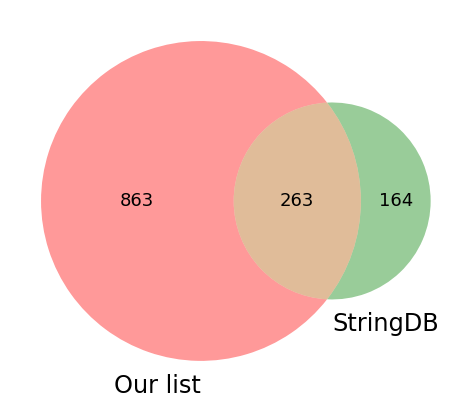

In [47]:
shared = stringbd_synapse_genes.intersection(synapse_genes)
num_shared = len(shared)
a = len(synapse_genes) - num_shared
b = len(stringbd_synapse_genes) - num_shared
ab = len(shared)

fig, ax = plt.subplots(figsize=(9,7))
v = matplotlib_venn.venn2(subsets=(a, b, ab), set_labels=['Our list', 'StringDB'])

text = v.get_label_by_id('01'); transform(text)
text = v.get_label_by_id('11'); transform(text)
text = v.get_label_by_id('10'); transform(text)
text = v.get_label_by_id('A'); transform(text, 24)
text = v.get_label_by_id('B'); transform(text, 24)

fn = os.path.join(output_dir, 'venn_diagram')
fig.savefig(fn, dpi=200)


## Filtering StringDB interactions for synapse genes 

In [48]:
stringdb_fn = '../data/StringDB/9606.protein.links.full.v11.0.txt.gz'
combined_synapse_genes = synapse_genes.union(stringbd_synapse_genes)

In [49]:
synapse_interactions_fn = os.path.join(output_dir, 'string_synapse_interactions.tsv')
with gzip.open(stringdb_fn) as fr, open(synapse_interactions_fn, 'w') as fw: 
    header = next(fr).decode()
    for line in fr: 
        
        line = line.decode()
        line = line.split()
        node1 = line[0]
        node2 = line[1]
        
        node1_name = prot_data[node1][0]
        node2_name = prot_data[node2][0]
        
        #         node, node2, node1_id, node2_id, \
        #         node1_ext_id, node2_ext_id, nbr_on_chrom, gene_fusion, \
        #         phylo_co, homology, coexpression, exp_interaction, \
        #         database_anno, auto_textmine, combined_score = line.split('\t')
        
        if node1_name in combined_synapse_genes or \
                node2_name in combined_synapse_genes: 
                
            s = [node1_name, node2_name, line[-1]]
            s = [str(x) for x in s]
            s = '\t'.join(s) + '\n'
            fw.write(s)
        